# Bike sharing problem

You can get the dataset here: https://www.kaggle.com/competitions/bike-sharing-demand
It is worth mentioning the neural network-based models I am presenting were NOT hyperparameter-tunned. I just wrote this code for fun, so I did not want to do more works...

## 1. GBR
### 1.1. Raw data processor for gradient boosted regression algorithm
We will:
* drop ["casual", "registered"] columns, as they are unknown before observing the true demand data.
* separate datetime into year, month, day and hour, since we would like to use them as covariates information. Note that the dataset is registered in hourly basis, meaning, we will only consider year, month, day and hour as time covariates.

In [1]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(15,7.5)})

In [2]:
import pandas as pd
train = pd.read_csv("data/train.csv", parse_dates = ["datetime"])
test = pd.read_csv("data/test.csv", parse_dates = ["datetime"])
features = list(train)[:-3]
label = list(train)[-1]

def preprocessor(df, features):
    df["year"] = pd.to_datetime(df['datetime']).dt.year
    df["month"] = pd.to_datetime(df['datetime']).dt.month
    df["day"] = pd.to_datetime(df['datetime']).dt.day
    df["hour"] = pd.to_datetime(df['datetime']).dt.hour
    try:
        return df[["year", "month", "day", "hour"] + features[1:]], df["count"]
    except:
        return df[["year", "month", "day", "hour"] + features[1:]]

In [3]:
train_x, train_y = preprocessor(train, features)
test_x = preprocessor(test, features)

Code below shows there is no nan, neither null data in our dataset:

In [4]:
print(train_x.info())
print(train_y.isnull().sum())
print(test_x.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        10886 non-null  int64  
 1   month       10886 non-null  int64  
 2   day         10886 non-null  int64  
 3   hour        10886 non-null  int64  
 4   season      10886 non-null  int64  
 5   holiday     10886 non-null  int64  
 6   workingday  10886 non-null  int64  
 7   weather     10886 non-null  int64  
 8   temp        10886 non-null  float64
 9   atemp       10886 non-null  float64
 10  humidity    10886 non-null  int64  
 11  windspeed   10886 non-null  float64
dtypes: float64(3), int64(9)
memory usage: 1020.7 KB
None
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        6493 non-null   int64  
 1   month       6493 non-n

### 1.2. Gradient boosting regressor
I brought the code below from https://www.kaggle.com/code/kongnyooong/bike-sharing-demand-for-korean-beginners/notebook, just for the comparison purposes with the neural network-based method. I was about to implement this myself, but since there is already implemented one, why? For further details, please check the code above.

## 2. Deep leearning

### 2.1. Data processing
* Unlike tree-based methods, such as XGBoost, neural network requires (or it better performs with) data normalization (or standardization).
* For the sake of data-scaling, we will perform batch normalization.
* For ancestral sampling purpose, we will append $z_{t-1}$ to input vector $x_t$, i.e. the RNN input vector will be $(z_{t-1},x_t)$ for timestep $t$, where $(z_s)_s$ is target series, and $(x_s)_s$ is known covariates.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
train = pd.read_csv("data/train.csv", parse_dates = ["datetime"])
test = pd.read_csv("data/test.csv", parse_dates = ["datetime"])
features = list(train)[:-3]
label = list(train)[-1]

def preprocessor(df, features):
    df["year"] = pd.to_datetime(df['datetime']).dt.year
    df["month"] = pd.to_datetime(df['datetime']).dt.month
    df["day"] = pd.to_datetime(df['datetime']).dt.day
    df["hour"] = pd.to_datetime(df['datetime']).dt.hour
    try:
        return df[["year", "month", "day", "hour"] + features[1:]], df["count"]
    except:
        return df[["year", "month", "day", "hour"] + features[1:]]

train_x, train_y = preprocessor(train, features)
test_x = preprocessor(test, features)

For the sake of implementational convenience, we will assume year, month, day, hour are continuous features. However, we strongly agree it is highly debatable if we would like to treat them as categorical feature or not.

In [6]:
train_x.head()

,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011,1,1,0,1,0,0,1,9.84,14.395,81,0.0
1,2011,1,1,1,1,0,0,1,9.02,13.635,80,0.0
2,2011,1,1,2,1,0,0,1,9.02,13.635,80,0.0
3,2011,1,1,3,1,0,0,1,9.84,14.395,75,0.0
4,2011,1,1,4,1,0,0,1,9.84,14.395,75,0.0


Note that there is high concentration of windspeed = 0, which is theoretically impossible.

(array([1.313e+03, 4.083e+03, 2.827e+03, 1.540e+03, 6.960e+02, 2.800e+02,
        1.070e+02, 3.100e+01, 6.000e+00, 3.000e+00]),
 array([ 0.     ,  5.69969, 11.39938, 17.09907, 22.79876, 28.49845,
        34.19814, 39.89783, 45.59752, 51.29721, 56.9969 ]),
 <BarContainer object of 10 artists>)

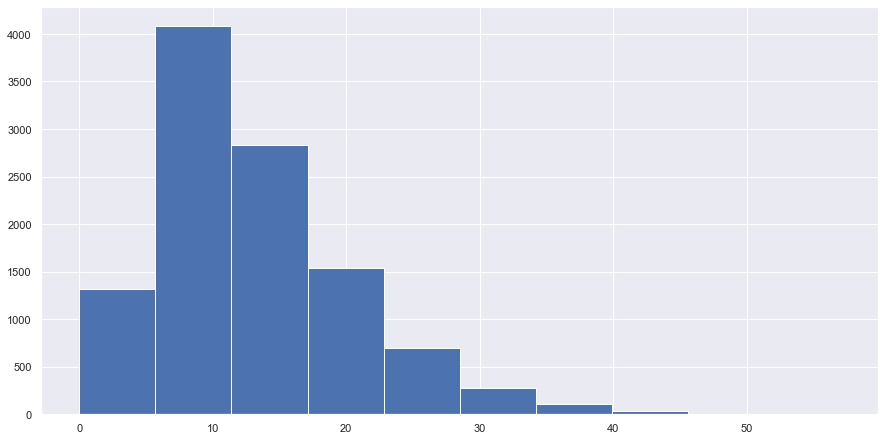

In [7]:
plt.hist(train_x["windspeed"])

* Assuming windspeed unavailable data were replaced by 0, let as drop this column. 
* Furthermore, both temp and atemp are almost linearly related with each other. Let us also drop atemp column, to reduce any issues due to high correlation.
* Lastly, we will change the domain of season feature to be between 0 and 3, instead of using 1 and 4.

In [4]:
cont_feat = ['year', 'month', 'day', 'hour', 'temp', 'humidity']
disc_feat = ['season', 'holiday', 'workingday', 'weather']
train_x['season'] = train_x['season'] - 1
train_x['weather'] = train_x['weather'] - 1
test_x['season'] = test_x['season'] - 1
test_x['weather'] = test_x['weather'] - 1
train_x = train_x[cont_feat + disc_feat]
test_x = test_x[cont_feat + disc_feat]

/var/folders/98/x8m1zwn15pldrsjr7xtrljz40000gn/T/ipykernel_1620/1614667601.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x['season'] = train_x['season'] - 1
/var/folders/98/x8m1zwn15pldrsjr7xtrljz40000gn/T/ipykernel_1620/1614667601.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x['weather'] = train_x['weather'] - 1
/var/folders/98/x8m1zwn15pldrsjr7xtrljz40000gn/T/ipykernel_1620/1614667601.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

We now have to apply MinMax scaling technique to continuous features:

In [5]:
from sklearn.preprocessing import MinMaxScaler
MMSc_feature = MinMaxScaler()
MMSc_feature.fit(train_x[cont_feat])
train_x[cont_feat] = MMSc_feature.transform(train_x[cont_feat])
test_x[cont_feat] = MMSc_feature.transform(test_x[cont_feat])

In [6]:
MMSc_label = MinMaxScaler()
MMSc_label.fit(np.asarray(train_y).reshape(-1,1))
train_y = MMSc_label.transform(np.asarray(train_y).reshape(-1,1))

Now, let us separate train dataset into both "other train" and "validation".

In [7]:
train = train_x.copy()
train["label"] = train_y
n = len(train)
train_df = train[0:int(n*0.7)]
val_df = train[int(n*0.7):int(n*0.9)]
test_df = train[int(n*0.9):]

It is shown in a variety of literature, that time series forcasting performance can be drastically enhanced by using the "previous target series value" as inputs. However, for the sake of simplicity of the code, we will skip such a step.

### 2.2. Tensorflow implementation for LSTM-based models

* Normalized log-transformed label has range 0 to 1. Since > 0, we would like to use ReLU() as the output activation function.

### 2.2.1. Time series window generation

Below, we will make tensorflow iterators for windowed arrays of format (batch_size, time steps, features).

In [9]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, LSTM, Dense, TimeDistributed, Softmax, Multiply, Lambda, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard
import tensorflow_probability as tfp


In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, train = True):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer)
  if train:
    dataset = dataset.batch(batch_size).prefetch(1)
  else:
    dataset = dataset.batch(series.shape[0]).prefetch(1)
  return dataset

In [11]:
window_size = 24
batch_size = 32
shuffle_buffer = 1000
train_dat = windowed_dataset(train_df, window_size, batch_size, shuffle_buffer)
validation_dat = windowed_dataset(val_df, window_size, batch_size, shuffle_buffer)
test_dat = windowed_dataset(test_df, window_size, batch_size, shuffle_buffer, train = False)

2022-06-20 03:23:03.390404: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Each train iterate are of the form:

In [ ]:
print(next(train_dat.as_numpy_iterator()).shape)

(32, 25, 11)


2022-06-18 00:53:52.388124: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


In [ ]:
train_dat

<PrefetchDataset shapes: (None, None, 11), types: tf.float64>

which looks like:

In [ ]:
pd.DataFrame(data = next(train_dat.as_numpy_iterator())[0, :, :]).head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.181818,0.055556,0.086957,0.204082,0.69,0.0,0.0,1.0,0.0,0.001025
1,0.0,0.181818,0.055556,0.130435,0.204082,0.69,0.0,0.0,1.0,0.0,0.003074
2,0.0,0.181818,0.055556,0.173913,0.183673,0.75,0.0,0.0,1.0,0.0,0.000000
3,0.0,0.181818,0.055556,0.217391,0.204082,0.69,0.0,0.0,1.0,0.0,0.004098
4,0.0,0.181818,0.055556,0.260870,0.204082,0.55,0.0,0.0,1.0,0.0,0.039959


while validation and test are of shape:

In [ ]:
print(next(validation_dat.as_numpy_iterator()).shape)
print(next(test_dat.as_numpy_iterator()).shape)

(32, 25, 11)
(1065, 25, 11)


And each batch looks like:

In [ ]:
pd.DataFrame(data = next(train_dat.as_numpy_iterator())[0, :, :]).head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.090909,0.722222,0.434783,0.428571,0.33,0.0,0.0,1.0,0.0,0.055328
1,0.0,0.090909,0.722222,0.478261,0.510204,0.23,0.0,0.0,1.0,0.0,0.053279
2,0.0,0.090909,0.722222,0.521739,0.551020,0.22,0.0,0.0,1.0,0.0,0.128074
3,0.0,0.090909,0.722222,0.565217,0.571429,0.19,0.0,0.0,1.0,0.0,0.121926
4,0.0,0.090909,0.722222,0.608696,0.591837,0.15,0.0,0.0,1.0,0.0,0.091189


Note that columns from
* 0 to 5 are ordinal features,
* 6 to 9 are categorical features,
* 10 is label

Let us define list of columns corresponding to:
* Ordinal features (=continuous features).
* Categorical features (=discrete features).
* Label

using the code below:

In [13]:
cont_feat_tf = list(range(0,6))
disc_feat_tf = list(range(6,10))
label_tf = [10]
# pd.DataFrame(data = next(train_dat.as_numpy_iterator())[0, :, :]).iloc[:, cont_feat_tf]

#### 2.2.2. Naive LSTM-based model

Now we will build a naive LSTM-based model for the forcasting problem. First, let's define the loss.

In [14]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

Now, we will define the embedding dimension for discrete features. We will follow a general rule from https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html, which suggests:
$$\text{Embedding dimension} = \sqrt[4]{\text{Number of categories}}$$

Decimals will be rounded to the closest integers.

In [15]:
def embedding_dimension(cat_num):
    return round(cat_num**0.25)

cat_nums = [4, 2, 2, 4] # 4 for season, 2 for holiday, 2 for working day, 4 for weather

Below, we have list of hyper parameters:

In [16]:
embedding_nums = [embedding_dimension(i) for i in cat_nums]
dropout_rates = 0
lstm_units = 64
l1_penalty = 0

Now, let's define the model:

In [ ]:
from tensorflow.keras.regularizers import l1

# Input layer
inp = tf.keras.Input((None, train.shape[1]-1), name = 'Input')

# Continous features
cont = K.stack([inp[:, :, i] for i in cont_feat_tf], axis = 2)

# Discrete features
cats_emb = []
for d_f in disc_feat_tf:
    cat_inp = inp[:, :, d_f]
    d_fm6 = d_f - 6
    cats_emb.append(Embedding(cat_nums[d_fm6], embedding_nums[d_fm6], name = "Embedding_{0}".format(disc_feat[d_fm6]))(cat_inp))
sub_embs = tf.concat([cont, K.stack(cats_emb, axis = 2)[:, :, :, 0]], axis =
 2)
full_embs = Dropout(dropout_rates)(sub_embs)

LSTM_out = tf.keras.layers.LSTM(lstm_units, return_sequences=True, name = "LSTM")(full_embs)
Output_dense = Dense(1, activation='relu', name='Output', kernel_regularizer=l1(l1_penalty))
Output = TimeDistributed(Output_dense, name='Output_timedistributed')(LSTM_out)


Below, let's compile the model:

In [ ]:
lstm_model = tf.keras.Model(inputs=inp, outputs=Output, name='Basic_LSTM')
lstm_model.compile(optimizer='adam', loss=rmse)

And now, let's train the model:

In [ ]:
epoch_num = 20
val_loss = []
for epoch in range(epoch_num):
    print("We are at epoch = {0}".format(epoch))
    for train_batch in train_dat.as_numpy_iterator():
        tr_x = train_batch[:, :, :-1]
        tr_y = np.expand_dims(train_batch[:, :, -1], axis=-1)
        lstm_model.fit(tr_x, tr_y, epochs=1, verbose=0, shuffle=False)
    vl_track = []
    for validation_batch in validation_dat.as_numpy_iterator():
        val_x = validation_batch[:, :, :-1]
        val_y = np.expand_dims(validation_batch[:, :, -1], axis=-1)
        vl_track.append(rmse(lstm_model.predict(val_x), val_y))
    val_loss.append(np.mean(vl_track))

We are at epoch = 0
We are at epoch = 1
We are at epoch = 2
We are at epoch = 3
We are at epoch = 4
We are at epoch = 5
We are at epoch = 6
We are at epoch = 7
We are at epoch = 8
We are at epoch = 9
We are at epoch = 10
We are at epoch = 11
We are at epoch = 12
We are at epoch = 13
We are at epoch = 14
We are at epoch = 15
We are at epoch = 16
We are at epoch = 17
We are at epoch = 18
We are at epoch = 19


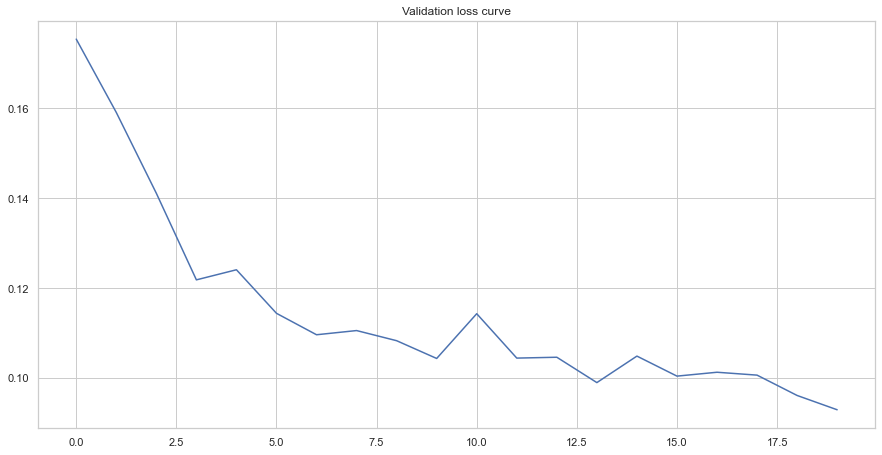

In [ ]:
sns.set_style("whitegrid")
plt.plot(val_loss)
plt.title("Validation loss curve")
plt.show()

Below is a prediction results for the first 50 timesteps:

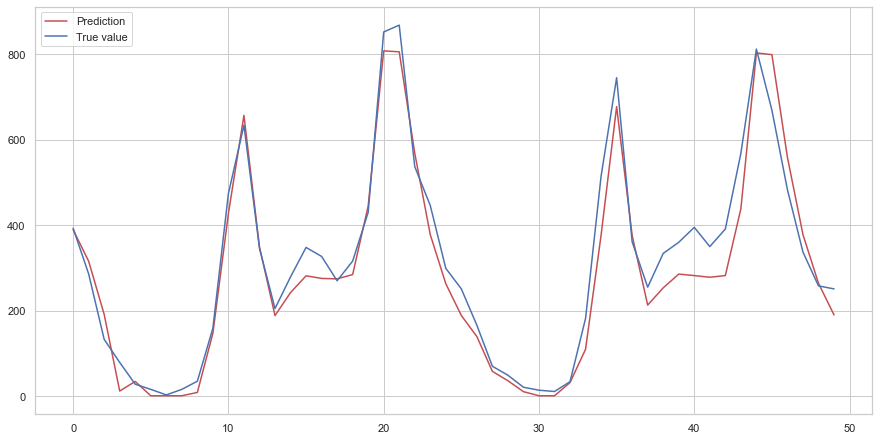

In [ ]:
pred_val = MMSc_label.inverse_transform(lstm_model(np.expand_dims(np.asarray(val_df.iloc[:50, :-1]), axis = 0))[:, :, 0])[0, :]
true_val = MMSc_label.inverse_transform(np.asarray(val_df.iloc[:50, -1]).reshape(-1,1))[:, 0]
plt.plot(pred_val, 'r', label = "Prediction")
plt.plot(true_val, 'b', label = "True value")
plt.legend(loc="upper left")
plt.show()

#### 2.2.3. DeepAR without ancestral sequence sampling functionality

DeepAR is a probabilistic time series forecasting model developed by Salinas et al. Here, I am just providing a simple implementation for this, in order to assess the performance of the model compared to the naive LSTM-based one.

To avoid any numerical issues, we will sum 1e-4 to standard deviation.

Also, my M1 macbook does not support tensorflow probability for some weird reason. I will borrow an existing implementaion of gaussian negative likelihood loss, and motify the code accordingly.

In [ ]:
# https://fairyonice.github.io/Create-a-neural-net-with-a-negative-log-likelihood-as-a-loss.html
def nll_gaussian(y_true, y_pred):
    ## element wise square
    mu = y_pred[:, :, 0]
    sigma = y_pred[:, :, 1] + 1e-4
    y_true = y_true[:, :, 0]
    square = tf.square(mu - y_true)## preserve the same shape as y_pred.shape
    ms = tf.divide(square,sigma) + K.log(sigma)
    ms = tf.reduce_mean(ms)
    return ms

Model hyperparameters are:

In [ ]:
embedding_nums = [embedding_dimension(i) for i in cat_nums]
dropout_rates = 0.1
lstm_units = 40
l1_penalty = 0.001

Let's define the model below.

In [ ]:
from tensorflow.keras.regularizers import l1

# Input layer
inp = tf.keras.Input((None, train.shape[1]-1), name = 'Input')

# Continous features
cont = K.stack([inp[:, :, i] for i in cont_feat_tf], axis = 2)

# Discrete features
cats_emb = []
for d_f in disc_feat_tf:
    cat_inp = inp[:, :, d_f]
    d_fm = d_f - disc_feat_tf[0]
    cats_emb.append(Embedding(cat_nums[d_fm], embedding_nums[d_fm], name = "Embedding_{0}".format(disc_feat[d_fm]))(cat_inp))
sub_embs = tf.concat([cont, tf.concat(cats_emb, axis = 2)], axis = 2)
full_embs = Dropout(dropout_rates)(sub_embs)

LSTM_out_1 = tf.keras.layers.LSTM(lstm_units, return_sequences=True, name = "LSTM_1")(full_embs)
LSTM_out_2 = tf.keras.layers.LSTM(lstm_units, return_sequences=True, name = "LSTM_2")(LSTM_out_1)
LSTM_out_3 = tf.keras.layers.LSTM(lstm_units, return_sequences=True, name = "LSTM_3")(LSTM_out_2)

Output_dense_mu = Dense(1, activation='linear', name='Output_mu', kernel_regularizer=l1(l1_penalty))
Output_dense_sigma = Dense(1, activation='softplus', name='Output_sigma', kernel_regularizer=l1(l1_penalty))
mu = TimeDistributed(Output_dense_mu, name='Mu_TD')(LSTM_out_3)
sigma = TimeDistributed(Output_dense_sigma, name='Sigma_TD')(LSTM_out_3)

DeepAR_model = tf.keras.Model(inputs=inp, outputs=tf.concat([mu, sigma], axis = 2), name='DeepAR')
DeepAR_model.compile(optimizer='adam', loss=nll_gaussian)


In [ ]:
epoch_num = 30
val_loss = []
for epoch in range(epoch_num):
    print("We are at epoch = {0}".format(epoch))
    for train_batch in train_dat.as_numpy_iterator():
        tr_x = train_batch[:, :, :-1]
        tr_y = np.expand_dims(train_batch[:, :, -1], axis=-1)
        DeepAR_model.fit(tr_x, tr_y, epochs=1, verbose=0, shuffle=False)
    DeepAR_model.save_weights(os.getcwd() + "/DeepAR_weights/{0}.pth".format(epoch))
    vl_track = []
    for validation_batch in validation_dat.as_numpy_iterator():
        val_x = validation_batch[:, :, :-1]
        val_y = np.expand_dims(validation_batch[:, :, -1], axis=-1)
        vl_track.append(rmse(DeepAR_model.predict(val_x), val_y))
    val_loss.append(np.mean(vl_track))

We are at epoch = 0
We are at epoch = 1
We are at epoch = 2
We are at epoch = 3
We are at epoch = 4
We are at epoch = 5
We are at epoch = 6
We are at epoch = 7
We are at epoch = 8
We are at epoch = 9
We are at epoch = 10
We are at epoch = 11
We are at epoch = 12
We are at epoch = 13
We are at epoch = 14
We are at epoch = 15
We are at epoch = 16
We are at epoch = 17
We are at epoch = 18
We are at epoch = 19
We are at epoch = 20
We are at epoch = 21
We are at epoch = 22
We are at epoch = 23
We are at epoch = 24
We are at epoch = 25
We are at epoch = 26
We are at epoch = 27
We are at epoch = 28
We are at epoch = 29


It seems like epoch 20 is the reasonable one to pick.

In [ ]:
good_epoch = 20
DeepAR_model.load_weights(os.getcwd() + "/DeepAR_weights/{0}.pth".format(good_epoch))

Below, we have the prediction results for the validation dataset:

In [ ]:
pred_val = MMSc_label.inverse_transform(DeepAR_model(np.expand_dims(np.asarray(val_df.iloc[:50, :-1]), axis = 0))[:, :, 0])[0, :]
pred_sigma = MMSc_label.inverse_transform(np.sqrt(DeepAR_model(np.expand_dims(np.asarray(val_df.iloc[:50, :-1]), axis = 0))[:, :, 1]))[0, :]
true_val = MMSc_label.inverse_transform(np.asarray(val_df.iloc[:50, -1]).reshape(-1,1))[:, 0]

z_score = 1.65
LB = np.clip(pred_val - z_score*pred_sigma, a_min = 0, a_max = None)
UB = np.clip(pred_val + z_score*pred_sigma, a_min = 0, a_max = None)

The plot below shows approx 90% of prediction interval surrounding mean value forecasts:

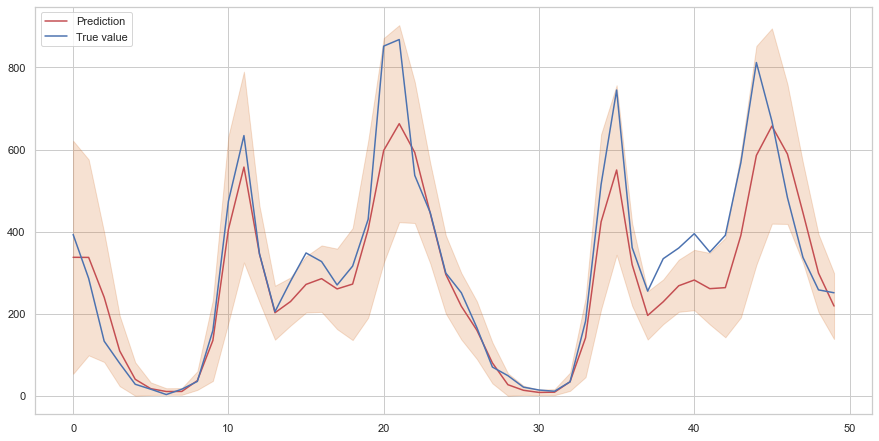

In [ ]:
plt.plot(pred_val, 'r', label = "Prediction")
plt.fill_between(range(50), LB, UB, color='chocolate', alpha=0.2)
plt.plot(true_val, 'b', label = "True value")
plt.legend(loc="upper left")
plt.show()

Note: A rigorous implementation of DeepAR requires to feed value of previous RNN output as the new input to the forecasts, which is the step I skipped, since I just wanted to play with the dataset.

### 2.2.4. DeepAR with ancestral forecasting functionality

Below, we will make DeepAR implementation using Tensorflow. 
During the training phase, the network will receive:
$$(z_{t-1},x_t)$$
with aim to predict
$$z_t$$
where $(z_t)_t$ is target series, and $(x_t)_t$ is covariates.

We will be using negative Gaussian log likelihood as the objective function.

In [12]:
train = train_x.copy()
train["label"] = train_y
n = len(train)
train_df = train[0:int(n*0.7)]
val_df = train[int(n*0.7):int(n*0.9)]
test_df = train[int(n*0.9):]

In [13]:
col_list = ['prev_label', 'year', 'month', 'day', 'hour', 'temp', 'humidity', 'season', 'holiday', 'workingday', 'weather', 'label']
train_df["prev_label"] = train_df["label"].shift(1).fillna(0)
train_df = train_df[col_list]
val_df["prev_label"] = val_df["label"].shift(1).fillna(0.469262)
val_df = val_df[col_list]
test_df["prev_label"] = test_df["label"].shift(1).fillna(0.389344)
test_df = test_df[col_list]

/var/folders/98/x8m1zwn15pldrsjr7xtrljz40000gn/T/ipykernel_1620/2397742870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["prev_label"] = train_df["label"].shift(1).fillna(0)
/var/folders/98/x8m1zwn15pldrsjr7xtrljz40000gn/T/ipykernel_1620/2397742870.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["prev_label"] = val_df["label"].shift(1).fillna(0.469262)
/var/folders/98/x8m1zwn15pldrsjr7xtrljz40000gn/T/ipykernel_1620/2397742870.py:6: SettingWithCopyWarning: 
A value is trying to be s

Train dataset looks like:

In [14]:
train_df.head(5)

,prev_label,year,month,day,hour,temp,humidity,season,holiday,workingday,weather,label
0,0.000000,0.0,0.0,0.0,0.000000,0.224490,0.81,0,0,0,0,0.015369
1,0.015369,0.0,0.0,0.0,0.043478,0.204082,0.80,0,0,0,0,0.039959
2,0.039959,0.0,0.0,0.0,0.086957,0.204082,0.80,0,0,0,0,0.031762
3,0.031762,0.0,0.0,0.0,0.130435,0.224490,0.75,0,0,0,0,0.012295
4,0.012295,0.0,0.0,0.0,0.173913,0.224490,0.75,0,0,0,0,0.000000


Let's define the iterator:

In [15]:
window_size = 24
batch_size = 32
shuffle_buffer = 1000
train_dat = windowed_dataset(train_df, window_size, batch_size, shuffle_buffer)
validation_dat = windowed_dataset(val_df, window_size, batch_size, shuffle_buffer)
test_dat = windowed_dataset(test_df, window_size, batch_size, shuffle_buffer, train = False)

Note that unlike the previous analysis we did, we now have "previous label" as also part of features. Note that the very initial value of prev_label was replaced by 0, as this is not known.

Below, we have DeepAR model parameter definition:

In [16]:
def embedding_dimension(cat_num):
    return round(cat_num**0.25)

In [17]:
class DeepAR_tf_params():
    def __init__(self):
        self.cat_nums = None
        self.cont_feat = None
        self.cont_feat_tf = None
        self.disc_feat = None
        self.disc_feat_tf = None
        self.dropout_rates = None
        self.embedding_nums = None
        self.label_tf = None
        self.lstm_num = None
        self.lstm_units = None
        self.l1_penalty = None

cont_feat = ['prev_label', 'year', 'month', 'day', 'hour', 'temp', 'humidity']
disc_feat = ['season', 'holiday', 'workingday', 'weather']

params = DeepAR_tf_params()
params.cat_nums = [4, 2, 2, 4] # Due to numerical issue, we are expanding cat_num
params.cont_feat = cont_feat
params.disc_feat = disc_feat
params.cont_feat_tf = list(range(0,7))
params.disc_feat_tf = list(range(7,11))
params.dropout_rates = 0
params.embedding_nums = [embedding_dimension(i) for i in params.cat_nums]
params.lstm_num = 3
params.label_tf = [11]
params.lstm_units = 40
params.l1_penalty = 0
params.lr = 0.0003

Now, let's build DeepAR model. We will:
* Train the network using the true label.
* Assess the validation performance via ancestral sampling with 6 step forecasting results.

**NOTE**: The model assumes we have at least one categorical and one ordinal features, with the last feature dimension being the label.

In [18]:
from tensorflow.keras.regularizers import l1

class DeepAR_tf(tf.keras.Model):
  def __init__(self, D_p:DeepAR_tf_params):
    super().__init__(self)
    self.params = D_p
    self.cat_embeddings = [Embedding(self.params.cat_nums[d_f - self.params.disc_feat_tf[0]], self.params.embedding_nums[d_f - self.params.disc_feat_tf[0]], name = "Embedding_{0}".format(self.params.disc_feat[d_f - self.params.disc_feat_tf[0]])) for d_f in self.params.disc_feat_tf]
    self.lstms = [tf.keras.layers.LSTM(self.params.lstm_units, return_sequences=True, return_state=True, name = "LSTM_{0}".format(i)) for i in range(self.params.lstm_num)]
    self.mu = Dense(1, activation='linear', name='mu', kernel_regularizer=l1(self.params.l1_penalty))
    self.sigma = Dense(1, activation='softplus', name='sigma', kernel_regularizer=l1(self.params.l1_penalty))

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    continuous_features = K.stack([x[:, :, i] for i in self.params.cont_feat_tf], axis = 2)
    discrete_features = tf.concat([self.cat_embeddings[i - self.params.disc_feat_tf[0]](tf.cast(x[:, :, i], tf.int64), training = training) for i in self.params.disc_feat_tf], axis = 2)
    x = tf.concat([continuous_features, discrete_features], axis = 2)
    x = Dropout(self.params.dropout_rates)(x)
    if states is None:
      states = [self.lstms[i].get_initial_state(x) for i in range(self.params.lstm_num)]
    for i in range(self.params.lstm_num):
      x, memory_i, carry_i = self.lstms[i](x, initial_state=states[i], training=training)
      states[i] = [memory_i, carry_i]
    mu = self.mu(x, training = training)
    sigma = self.sigma(x, training = training)
    x = tf.concat([mu, sigma], axis = 2)
    if return_state:
      return x, states
    else:
      return x

In [121]:
DeepAR_tf_model = DeepAR_tf(params)
for i in train_dat.take(1):
    for t in range(i.shape[1]):
        tr_x = K.expand_dims(i[:, t, :-1], axis = 1)
        tr_y = i[:, t, -1]
        example_pred = DeepAR_tf_model(tr_x)

In [122]:
DeepAR_tf_model.summary()

Model: "deep_ar_tf_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_season (Embedding) multiple                  4         
_________________________________________________________________
Embedding_holiday (Embedding multiple                  2         
_________________________________________________________________
Embedding_workingday (Embedd multiple                  2         
_________________________________________________________________
Embedding_weather (Embedding multiple                  4         
_________________________________________________________________
LSTM_0 (LSTM)                multiple                  8320      
_________________________________________________________________
LSTM_1 (LSTM)                multiple                  12960     
_________________________________________________________________
LSTM_2 (LSTM)                multiple                

Now, let's compile the model:

In [19]:
# https://fairyonice.github.io/Create-a-neural-net-with-a-negative-log-likelihood-as-a-loss.html
def nll_gaussian(y_true, y_pred):
    ## element wise square
    mu = y_pred[:, 0, 0]
    sigma = y_pred[:, 0, 1] + 1e-4
    y_true = tf.cast(y_true, tf.float32)
    square = tf.square(mu - y_true)## preserve the same shape as y_pred.shape
    ms = tf.divide(square,sigma) + K.log(sigma)
    ms = tf.reduce_mean(ms)
    return ms

**NOTE**: Now, I need to write the custom training loop below (get loss += for each time step, and update the weight at the end).

Try to do this like in Pytorch.


In [20]:
def grad(model, inputs, targets):
  loss_value = tf.zeros(1)
  stat = None
  with tf.GradientTape() as tape:
    for t in range(inputs.shape[1]):
      features = K.expand_dims(inputs[:, t, :], axis = 1)
      if stat == None:
        y_pred, stat = model(features, return_state = True, training = True)
      else:
        y_pred, stat = model(features, states = stat, return_state = True, training = True)
      loss_value += nll_gaussian(targets[:, t], y_pred)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [21]:
## Note: Rerunning this cell uses the same model variables
DeepAR_tf_model = DeepAR_tf(params)
optimizer = tf.keras.optimizers.Adam(learning_rate=params.lr)

In [22]:
# Keep results for plotting
train_loss_results = []

num_epochs = 30

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()

  # Training loop - using batches of 32
  for i in train_dat:
    x = i[:, :, :-1]
    y = i[:, :, -1]
    # Optimize the model
    loss_value, grads = grad(DeepAR_tf_model, x, y)
    optimizer.apply_gradients(zip(grads, DeepAR_tf_model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())

  print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

2022-06-20 03:23:43.850444: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 000: Loss: -56.133
Epoch 001: Loss: -75.951
Epoch 002: Loss: -82.138
Epoch 003: Loss: -91.296
Epoch 004: Loss: -98.609
Epoch 005: Loss: -104.322
Epoch 006: Loss: -110.236
Epoch 007: Loss: -114.948
Epoch 008: Loss: -118.747
Epoch 009: Loss: -121.698
Epoch 010: Loss: -124.945
Epoch 011: Loss: -127.826
Epoch 012: Loss: -130.824
Epoch 013: Loss: -133.912
Epoch 014: Loss: -136.476
Epoch 015: Loss: -138.797
Epoch 016: Loss: -140.905
Epoch 017: Loss: -142.955
Epoch 018: Loss: -144.977
Epoch 019: Loss: -146.170
Epoch 020: Loss: -147.689
Epoch 021: Loss: -148.655
Epoch 022: Loss: -150.134
Epoch 023: Loss: -150.825
Epoch 024: Loss: -152.158
Epoch 025: Loss: -153.053
Epoch 026: Loss: -153.616
Epoch 027: Loss: -154.884
Epoch 028: Loss: -155.674
Epoch 029: Loss: -156.126


In [210]:
# f_starting = 10

In [ ]:
# pred_val = MMSc_label.inverse_transform(DeepAR_model(np.expand_dims(np.asarray(val_df.iloc[:50, :-1]), axis = 0))[:, :, 0])[0, :]
# pred_sigma = MMSc_label.inverse_transform(np.sqrt(DeepAR_model(np.expand_dims(np.asarray(val_df.iloc[:50, :-1]), axis = 0))[:, :, 1]))[0, :]
# true_val = MMSc_label.inverse_transform(np.asarray(val_df.iloc[:50, -1]).reshape(-1,1))[:, 0]

# z_score = 1.65
# LB = np.clip(pred_val - z_score*pred_sigma, a_min = 0, a_max = None)
# UB = np.clip(pred_val + z_score*pred_sigma, a_min = 0, a_max = None)

In [23]:
f_starting = 0
i = K.expand_dims(val_df.iloc[:50, :], axis = 0)
states = None
x = i[:, :, :-1].numpy()
y_hat = tf.zeros(i[:, :, -1].shape).numpy()
y = i[:, :, -1].numpy()
std = tf.zeros(i[:, :, -1].shape).numpy()
for t in range(x.shape[1]):
  features = K.expand_dims(x[:, t, :], axis = 1)
  if states == None:
    y_pred, states = DeepAR_tf_model(features, return_state = True, training = False)
  else:
    y_pred, states = DeepAR_tf_model(features, states = states, return_state = True, training = False)
  if t < x.shape[1]-1 and t >= f_starting:
    x[:, t+1, 0] = y_pred[:, 0, 0]
    y_hat[:, t] = y_pred[:, 0, 0]
    std[:, t] = y_pred[:, 0, 1]
  elif t < f_starting:
    y_hat[:, t] = x[:, t+1, 0]
    std[:, t] = 0*y_pred[:, 0, 1]
  else:
    y_hat[:, t] = y_pred[:, 0, 0]
    std[:, t] = y_pred[:, 0, 1]
      

In [24]:
pred_val = MMSc_label.inverse_transform(y_hat)
pred_sigma = MMSc_label.inverse_transform(np.sqrt(std))
true_val = MMSc_label.inverse_transform(y)

z_score = 1.65
LB = np.clip(pred_val - z_score*pred_sigma, a_min = 0, a_max = None)
UB = np.clip(pred_val + z_score*pred_sigma, a_min = 0, a_max = None)

In [29]:
true_val.shape

(1, 50)

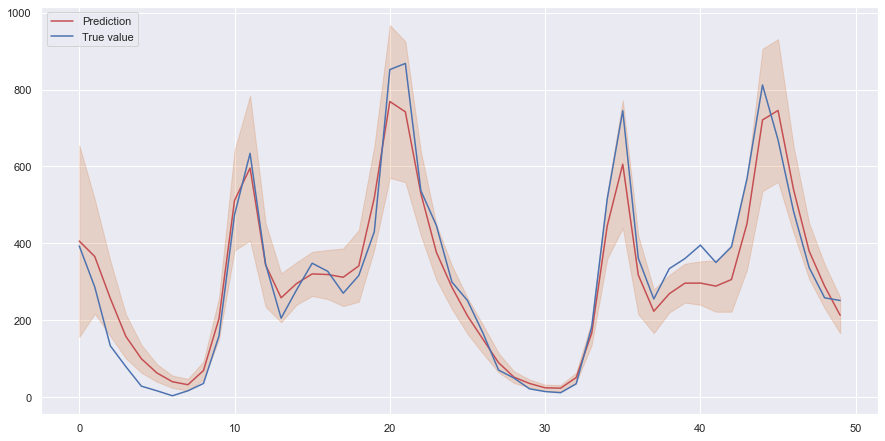

In [30]:
plt.plot(pred_val[0, :], 'r', label = "Prediction")
plt.fill_between(range(y_hat.shape[1]), LB[0, :], UB[0, :], color='chocolate', alpha=0.2)
plt.plot(true_val[0, :], 'b', label = "True value")
plt.legend(loc="upper left")
plt.show()